In [2]:
#Load packages
import networkx as nx
import os
import pandas as pd
import numpy as np
import math
import random
import time
import powerlaw
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#load dataset
cwd = os.getcwd()

chatter_data = pd.read_csv(cwd+'\\Data\\chatter_membership_10_clean.csv', encoding='utf-8')
print(chatter_data.shape)

(156603, 8)


94


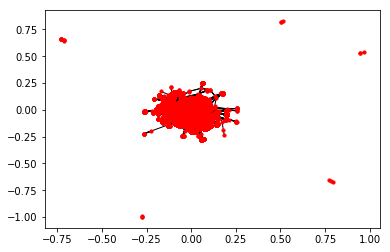

Time to complete process: 528.978sec


In [6]:
# create the network
# TAKES A LONG TIME TO RENDER GRAPH. ONLY DRAW IF USING A SMALL SAMPLE
G = nx.Graph()
target_list = chatter_data['Name'].unique().tolist()
sample_list = random.sample(target_list, int(float(len(target_list))*1)) #take a smaller sample

print(len(sample_list))

start=time.clock()
print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))

start2=time.clock()
for t in sample_list:
    if i % 100 == 0:
       end2=time.clock()
       print(str(round((i/(len(sample_list)))*100,1))+'% Completed in '+str(round(end2-start2,3)))
       start2=time.clock()
    chatter_single_user = chatter_data.loc[chatter_data['Name'] == t]
    #get list with one item that is the group name
    target = chatter_single_user['Name'].unique().tolist() 
    #create list of all people who are members of the group
    poster = chatter_single_user['USER_NAME_ID'].unique().tolist()
      
    G.add_node(target[0])
    G.add_nodes_from(poster)
    G.add_edges_from([(target[0], p) for p in poster])
    
#nx.draw_networkx(G, pos=None, node_size = 10, with_labels=False)
#plt.show()

end=time.clock()
print("Time to complete process: "+str(round(end-start,3))+"sec")

In [7]:
#export config model to gephi
G_max = max( (G.subgraph(c) for c in nx.connected_components(G) ), key=len)
print(nx.number_connected_components(G))

G_max = nx.Graph(G_max)
print(type(G_max).__name__)

nx.write_gexf(G, "ChatterGroups.gexf")

6
Graph


### Analysis of the Graph

In [8]:
def neighbor_degree(node, nxgraph):
    avg_degree = np.mean([nxgraph.degree(n) for n in nxgraph.neighbors(node)])
    return avg_degree

def friendship_paradox(nxgraph):
    pdox_ct = 0
    for n in nxgraph.nodes():
        if nxgraph.degree(n) < neighbor_degree(n, nxgraph):
            pdox_ct += 1
    return pdox_ct / len(nxgraph)

In [9]:
# TAKES A LONG TIME IF YOU RUN AVG SHORTEST PATH AND AVG CLUSTERING ~ 5000sec
start=time.clock()

print(nx.info(G))
print('Friendship Paradox: '+str(round(friendship_paradox(G),4)))
print('Graph Density: '+str(round(nx.density(G),4)))
#print('Avg Clustering Coefficient: '+str(nx.average_clustering(G)))
#print('Avg Shortest Path: '+str(round(nx.average_shortest_path_length(G, weight=None),4)))

end=time.clock()
print("Time to complete process: "+str(round(end-start,3))+"sec")

Name: 
Type: Graph
Number of nodes: 13404
Number of edges: 17491
Average degree:   2.6098
Friendship Paradox: 0.9931
Graph Density: 0.0002
Time to complete process: 0.394sec


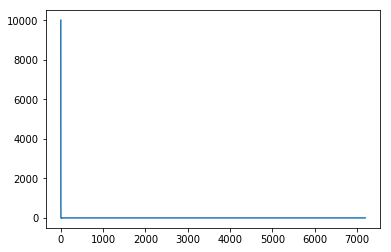

In [10]:
deg_seq = list(dict(nx.degree(G)).values())
nk = Counter(deg_seq)

x = []
y = []
for k in sorted(nk):
    x.append(k)
    y.append(nk[k])
    
plt.plot(x,y)
plt.show()

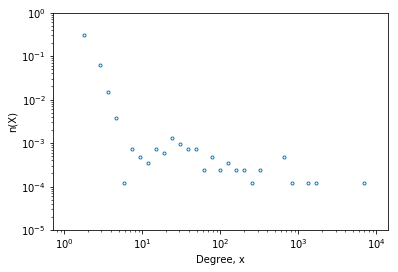

In [11]:
deg_seq = list(dict(nx.degree(G)).values())
bins = np.logspace(0.0, 4.0, num=40)

Y, X = np.histogram(deg_seq, bins=bins, normed=True)

X = [x*np.sqrt(bins[1]) for x in X][:-1]

plt.ylim((0.00001, 1))
plt.xlabel('Degree, x')
plt.ylabel("n(X)")
plt.loglog(X,Y, 'o', markersize=3, markerfacecolor='none')
plt.show()

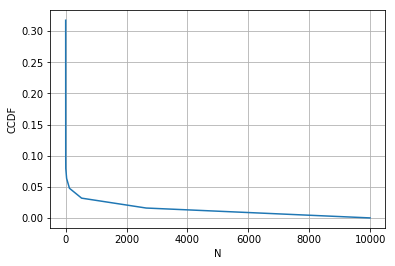

In [13]:
def cdf(data):
    data_size=len(data)
    
    # Set bins edges
    data_set=sorted(set(data))
    bins=np.append(data_set, data_set[-1]+1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts=counts.astype(float)/data_size

    # Find the cdf
    cdf = np.cumsum(counts)
    
    return cdf, bin_edges

cdf, bin_edges = cdf(y)

# Plot the cdf
plt.plot(bin_edges[0:-1], 1-cdf) #1 - cdf to get ccdf
#plt.xscale('log')
#plt.yscale('log')
#plt.ylim((0,1))
plt.ylabel("CCDF")
plt.xlabel("N")
plt.grid(True)

plt.show()

Calculating best minimal value for power law fit
c:\users\ahilgenkamp\appdata\local\programs\python\python36\lib\site-packages\powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
c:\users\ahilgenkamp\appdata\local\programs\python\python36\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


20.0
1.7603153406940892
21.49116915067745 1.7703029947790694


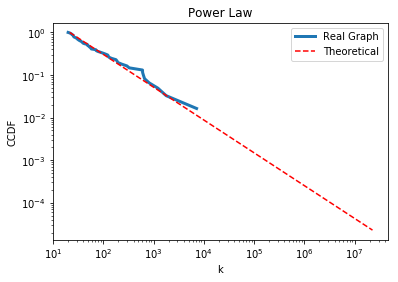

In [15]:
# Find the cut-off
node_degrees = deg_seq
fit = powerlaw.Fit(node_degrees)
print(fit.xmin)

# estimate the scaling exponent
alpha = fit.power_law.alpha
print(alpha)

# plot vs theoretical distribution
theoretical_distribution = powerlaw.Power_Law(xmin=20.0, parameters=[1.76])
simulated_data = theoretical_distribution.generate_random(10000)
fit2 = powerlaw.Fit(simulated_data)
print( fit2.power_law.xmin, fit2.power_law.alpha )

fig = fit.plot_ccdf(linewidth=3, label='Real Graph')
fit2.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Theoretical')
plt.title('Power Law')
plt.ylabel("CCDF")
plt.xlabel("k")
plt.legend()

plt.show()